In [1]:
# google colab + google drive sync
from google.colab import drive
drive.mount('/content/gdrive/')
!ls
%cd gdrive/MyDrive/Colab Notebooks/G-ABC-Infection/AI-Infection-main

# library install
!pip install gpytorch
# requirements.txt file generation
!pip freeze > requirements.txt

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
gdrive	sample_data
/content/gdrive/MyDrive/Colab Notebooks/G-ABC-Infection/AI-Infection-main


In [1]:
import pandas as pd
import numpy as np
import xlrd
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import os
import random
from gpytorch.mlls import SumMarginalLogLikelihood
from itertools import repeat

In [2]:
''' fix random seed for reproduce '''
random_seed = 1000
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

데이터 로드 및 전처리

In [8]:
''' data read '''
xls = pd.ExcelFile('data/수집데이터_210924.xlsx')


x_holiday = pd.read_excel(xls,sheet_name='국가별공휴일',engine='openpyxl')
x_dist = pd.read_excel(xls,sheet_name='사회적거리두기_Score',engine='openpyxl')
x_vaccine = pd.read_excel(xls,sheet_name='백신접종자수',engine='openpyxl')
x_weather = pd.read_excel(xls,sheet_name='국가별수도날씨',engine='openpyxl')
x_population = pd.read_excel(xls,sheet_name='국가별인구수',engine='openpyxl')
x_variant = pd.read_excel(xls,sheet_name='변이바이러스 비율',engine='openpyxl')
y_inspection = pd.read_excel(xls,sheet_name='검사자 데이터 통합',engine='openpyxl')
y_infection = pd.read_excel(xls,sheet_name='확진자 데이터 통합',engine='openpyxl')
y_death = pd.read_excel(xls,sheet_name='사망자 데이터 통합',engine='openpyxl')

In [9]:
start_date = pd.Timestamp('2020-01-01')
observed_end_date = pd.Timestamp('2021-09-15') # "사망자 데이터 통합"등에 기록된 최종 일자
end_date = pd.Timestamp('2022-12-31')
date = pd.date_range(start_date,end_date)
country_list = y_inspection.columns.values.tolist()[1:]
country_idx_dict = {key:val for val,key in enumerate(country_list)}

num_country = len(country_list)
td = (end_date - start_date).days + 1 # total date, 2020-01-02 - 2020-01-01 = 1

# GP에 넣기 위한 빈공간 생성
x = np.zeros((6,num_country,td)) # 6: 날짜 + 위 셀에서 불러온 데이터 x 5개 (국가별인구수는 제외)
y = np.zeros((3,num_country,td)) # 3: 검사자, 확진자, 사망자

In [10]:
# 인구수
country_population_dict = {}
for row in x_population.iterrows():
  country, pro1, pro2, num = row[1]
  if type(pro1) == float:
    country_population_dict[country] = num
country_population_dict['Czechia'] = 10650000
country_population_dict['Latvia'] = 1920000
country_population_dict['US'] = 328200000

In [11]:
# 날짜 
# 규칙: 0,1,2,3,4,...
for itr in range(td):
  x[0,:,itr] = itr 

In [12]:
# x_holiday 전처리
# 규칠: 공휴일:1 , 그 외: 0
for row in x_holiday.iterrows():
  current_date, country, _ = row[1]
  idx = (current_date - start_date).days
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[1,country_idx_dict[country],idx] = 1

In [13]:
# x_dist 전처리
# 규칙: 항목별 score 평균 (province별로 존재할 경우, 이 또한 평균)
country_end_dict = {}
group_x_dist = x_dist.groupby(['tDate', 'Country']).mean() # province별로 존재할 경우, 평균
for row in group_x_dist.iterrows():
  current_date, country = row[0]
  idx = (current_date - start_date).days
  dist = np.mean(row[1])
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    if (dist == 0) and (idx>0): # 관측되었지만, 0으로 누락된 경우를 고려하기 위함
      x[2,country_idx_dict[country],idx] = x[2,country_idx_dict[country],idx-1]
    else:
      x[2,country_idx_dict[country],idx] = dist
  country_end_dict[country] = idx
  
for country,country_end_idx in country_end_dict.items():
  if country in country_idx_dict:
    for itr in range(country_end_idx,td):
      x[2,country_idx_dict[country],itr] = x[2,country_idx_dict[country],country_end_idx]

In [14]:
# x_vaccine 전처리
# 규칙: 1차 백신 접종자수만 기록하되, 누적하여 기록 (0으로 결측일 경우, 그 이전 max 값 그대로 가져오기)
# 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
country_end_dict = {}
for row in x_vaccine.iterrows():
  current_date, country, num_vaccine, _ = row[1]
  idx = (current_date - start_date).days
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[3,country_idx_dict[country],idx] = np.maximum(num_vaccine, x[3,country_idx_dict[country],idx-1])
  country_end_dict[country] = idx

# 각 국가별 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
for country,country_end_idx in country_end_dict.items():
  if country in country_idx_dict:
    for itr in range(country_end_idx,td):
      x[3,country_idx_dict[country],itr] = x[3,country_idx_dict[country],country_end_idx]

In [15]:
# x_weather 전처리
# 규칙: Temp만 기록, city 별로는 평균
# 최신날짜부터, 2021-12-31까지는 1년전 값 유지
group_x_weather = x_weather.groupby(['tDate', 'Country']).mean() # province별로 존재할 경우, 평균
for row in group_x_weather.iterrows():
  current_date, country = row[0]
  idx = (current_date - start_date).days
  temp = row[1][0]
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[4,country_idx_dict[country],idx] = temp
for itr in range(idx,td):
  x[4,:,itr] = x[4,:,itr-365]

In [16]:
# x_variant 전처리
# 규칙: 21A.Delta 기록
# 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
# 중간 중간 빈 값은, 그 이전 값을 그대로 유지
country_end_dict = {}
prev_idx = 0
for row in x_variant.iterrows():
  country, current_date,variant,_,_,proportion = row[1]
  if variant == '21A.Delta':
    idx = (current_date - start_date).days
    if (idx >= 0) and (idx < td) and (country in country_idx_dict):
      x[5,country_idx_dict[country],prev_idx+1:idx+1] = proportion
    prev_idx = idx
    country_end_dict[country] = idx

# 각 국가별 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
for country,country_end_idx in country_end_dict.items():
  if country in country_idx_dict:
    for itr in range(country_end_idx,td):
      x[5,country_idx_dict[country],itr] = x[5,country_idx_dict[country],country_end_idx]

In [17]:
# y 전처리
for country,country_idx in country_idx_dict.items():
  country_inspection = y_inspection[country]
  country_infection = y_infection[country]
  country_death = y_death[country]

  y[0,country_idx,:len(country_inspection)] = country_inspection # from 2020-01-01
  y[1,country_idx,21:21+len(country_death)] = country_infection # from 2020-01-22
  y[2,country_idx,21:21+len(country_death)] = country_death # from 2020-01-22

In [18]:
# x 최종 전처리 (0~1사이의 범위로 변경)
x[0,:,:] = x[0,:,:]/td # 날짜
x[1,:,:] = x[1,:,:] # 그대로 0,1
x[2,:,:] = x[2,:,:]/100 # 거리두기 score
for country,country_idx in country_idx_dict.items():
  x[3,country_idx,:] = x[3,country_idx,:]/country_population_dict[country] # vaccine
x[4,:,:] = x[4,:,:]/np.max(x[4,:,:]) # weather
x[5,:,:] = x[5,:,:] # variant

In [20]:
# y 최종 전처리 (0~1사이의 범위로 변경)
max_list = []
for country,country_idx in country_idx_dict.items():
  max_list.append([np.max(y[0,country_idx,:]),np.max(y[1,country_idx,:]),np.max(y[2,country_idx,:])])
  y[0,country_idx,:] = y[0,country_idx,:]/np.max(y[0,country_idx,:]) # inspection
  y[1,country_idx,:] = y[1,country_idx,:]/np.max(y[1,country_idx,:]) # infection
  y[2,country_idx,:] = y[2,country_idx,:]/np.max(y[2,country_idx,:]) # death
  # y[0,country_idx,:] = y[0,country_idx,:]/country_population_dict[country] # inspection
  # y[1,country_idx,:] = y[1,country_idx,:]/country_population_dict[country] # infection
  # y[2,country_idx,:] = y[2,country_idx,:]/country_population_dict[country] # death

In [21]:
# numpy to pytorch tensor
torch_x = torch.from_numpy(x).float()
torch_y = torch.from_numpy(y).float()
print(x.shape,y.shape,torch.max(torch_x),torch.max(torch_y[2,:,:]))

(6, 40, 1096) (3, 40, 1096) tensor(1.) tensor(1.)


In [22]:
# train, test split
start_point = (pd.Timestamp('2020-09-01') - start_date).days # we remove data before 2020-09-01, many values are one or zero
# start_point = 366 # 2021-01-01 0~29: many values are one or zero
end_point = (observed_end_date-start_date).days

train_date = date[start_point:end_point]
train_x = torch_x[:,:,start_point:end_point]
train_y = torch_y[:,:,start_point:end_point]

test_date = date[end_point:]
test_x = torch_x[:,:,end_point:]
test_y = torch_y[:,:,end_point:]

print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

torch.Size([6, 40, 379]) torch.Size([6, 40, 473]) torch.Size([3, 40, 379]) torch.Size([3, 40, 473])


In [93]:
data_dim = train_x.size(0)
feature_dim = 10
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 64))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(64, 32))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(32, feature_dim))

feature_extractor = LargeFeatureExtractor()

In [104]:
# initialize model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()+gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=10)*gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=6)*gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=feature_dim))
        # self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=5,ard_num_dims=feature_dim)
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)
        self.feature_extractor = feature_extractor

    def forward(self, x):
        projected_x = self.feature_extractor(x)
        projected_x = self.scale_to_bounds(projected_x)
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [105]:
# initialize likelihood
model_list = []
likelihood_list = []
num_country = len(country_idx_dict)
'''
한국, 영국, 미국에 대해서 multi-output gp
'''
target_country_list = [32,38,39] # South Korea, United Kingdom, UK
for mode_itr in [1,2]: # 1: infection', 2: death
  for itr in range(num_country):
    if itr in target_country_list:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      model = ExactGPModel(train_x[:,itr,:].T, train_y[mode_itr,itr,:], likelihood)
      model_list.append(model)
      likelihood_list.append(model.likelihood)

In [106]:
model = gpytorch.models.IndependentModelList(*model_list)
likelihood = gpytorch.likelihoods.LikelihoodList(*likelihood_list)

In [107]:
# Use the adam optimizer
training_iter = 700
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

In [108]:
# training
model.train()
likelihood.train()

# "Loss" for GPs - the marginal log likelihood
mll = SumMarginalLogLikelihood(likelihood, model)
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    optimizer.step()
    if i%10 == 0:
      print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))

Iter 1/700 - Loss: 0.770
Iter 11/700 - Loss: 0.725
Iter 21/700 - Loss: 0.687
Iter 31/700 - Loss: 0.649
Iter 41/700 - Loss: 0.610
Iter 51/700 - Loss: 0.570
Iter 61/700 - Loss: 0.529
Iter 71/700 - Loss: 0.487
Iter 81/700 - Loss: 0.444
Iter 91/700 - Loss: 0.403
Iter 101/700 - Loss: 0.358
Iter 111/700 - Loss: 0.312
Iter 121/700 - Loss: 0.267
Iter 131/700 - Loss: 0.222
Iter 141/700 - Loss: 0.175
Iter 151/700 - Loss: 0.129
Iter 161/700 - Loss: 0.087
Iter 171/700 - Loss: 0.037
Iter 181/700 - Loss: -0.011
Iter 191/700 - Loss: -0.056
Iter 201/700 - Loss: -0.106
Iter 211/700 - Loss: -0.144
Iter 221/700 - Loss: -0.194
Iter 231/700 - Loss: -0.240
Iter 241/700 - Loss: -0.288
Iter 251/700 - Loss: -0.334
Iter 261/700 - Loss: -0.378
Iter 271/700 - Loss: -0.420
Iter 281/700 - Loss: -0.457
Iter 291/700 - Loss: -0.503
Iter 301/700 - Loss: -0.540
Iter 311/700 - Loss: -0.583
Iter 321/700 - Loss: -0.623
Iter 331/700 - Loss: -0.663
Iter 341/700 - Loss: -0.694
Iter 351/700 - Loss: -0.733
Iter 361/700 - Loss: 

In [109]:
# testing
concat_train_x = []
concat_test_x = []
for mode_itr in [1,2]:
  for itr in range(num_country):
    if itr in target_country_list:
      concat_train_x.append(train_x[:,itr,:].T)
      concat_test_x.append(test_x[:,itr,:].T)

model.eval()
likelihood.eval()
estimations = likelihood(*model(*concat_train_x))
predictions = likelihood(*model(*concat_test_x))

/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


In [110]:
def plot_figure(target_country,mode):
  target_country_population = country_population_dict[target_country]
  if mode == 1:
    name = 'Infection'
    if target_country == 'South Korea':
      target_country_idx = 0
      y_lim = [-1000,4000]
    elif target_country == 'United Kingdom':
      target_country_idx = 1
      y_lim = [-1000,80000]
    elif target_country == 'US':
      target_country_idx = 2
      y_lim = [-1000,450000]
  elif mode == 2:
    name = 'death'
    if target_country == 'South Korea':
      target_country_idx = 3
      y_lim = [-10,30]
    elif target_country == 'United Kingdom':
      target_country_idx = 4
      y_lim = [-1000,3000]
    elif target_country == 'US':
      target_country_idx = 5
      y_lim = [-1666,5000]

  submodel = model.models[target_country_idx]
  estimation = estimations[target_country_idx]
  prediction = predictions[target_country_idx]
  max_value = max_list[country_idx_dict[target_country]][mode]

  lower, upper = prediction.confidence_region()
  tr_x = submodel.train_inputs[0].detach().numpy()[:,0]
  tr_y = submodel.train_targets.detach().numpy()
  # Plot training data as black stars
  plt.plot(tr_x, tr_y*max_value, 'k*')

  # Predictive mean as blue line
  plt.plot(train_x[0,country_idx_dict[target_country],:].numpy(), estimation.mean.numpy()*max_value, 'b')
  plt.plot(test_x[0,country_idx_dict[target_country],:].numpy(), prediction.mean.numpy()*max_value, 'r')

  # Shade in confidence
  plt.fill_between(test_x[0,country_idx_dict[target_country],:].numpy(), 
                    lower.detach().numpy()*max_value, 
                    upper.detach().numpy()*max_value, alpha=0.5)
  plt.ylim(y_lim)
  plt.legend(['Observed Data', 'Mean', 'Confidence'])
  plt.title('Observed Values (Likelihood)')
  plt.legend(['Ground-Truth', 'Estimation', 'Prediction'])
  plt.ylabel(name)

  new_date = date[start_point:].to_numpy()
  y_loc = y_lim[0]*1.5

  plt.xticks([0.22,0.56,1.0], [str(new_date[int(len(new_date)*0.0)])[:10],
                                  str(new_date[end_point-start_point])[:10],
                                  str(end_date)[:10]],rotation=45,fontsize=10)

  plt.tight_layout()
  plt.savefig("results/"+str(target_country)+'_'+str(name),dpi=300)
  plt.show()

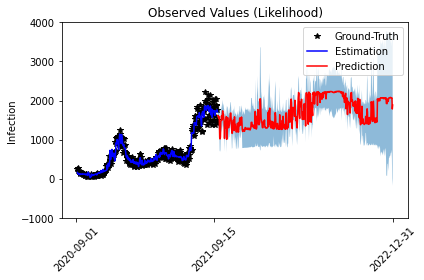

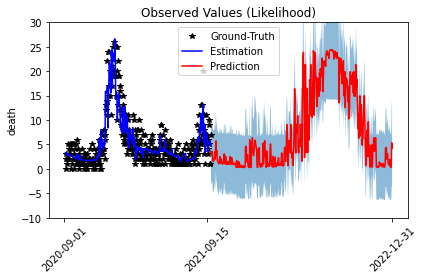

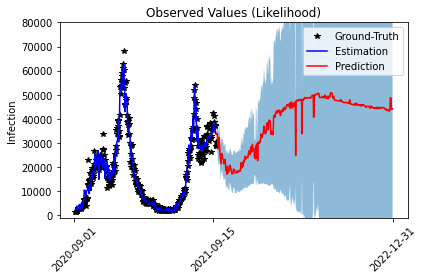

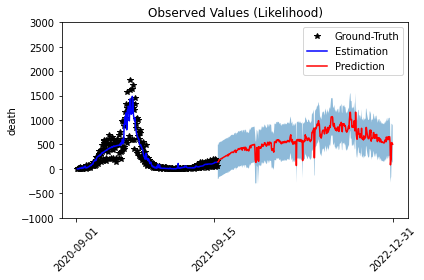

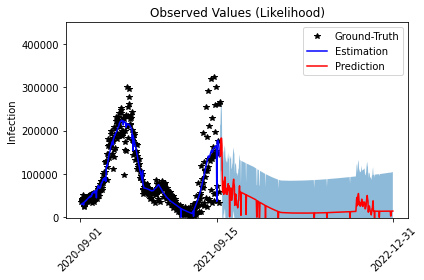

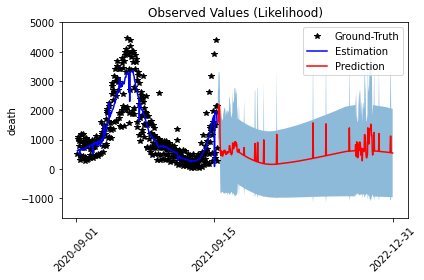

In [111]:
# visualization
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  target_country_list = ['South Korea','United Kingdom','US']
  mode_list = [1,2] # 1: infection', 2: death

  for target_country in target_country_list:
    for mode in mode_list: 
      plot_figure(target_country,mode)